In [71]:
%matplotlib inline

In [72]:
from skimage.io import collection, imread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import re
import glob

from datetime import datetime
import nltk

import yfinance as yf

# How is the public opinion about a company correlated to it's market value?

A company's market value is variable and depends on a lot of factors. The price is a reflection of the company's perceived value - what the public is willing to pay for a piece of the company. It can and will rise and fall, based on a variety of factors in the global landscape and within the company itself. One of which is becoming more influential than ever - people's opinion on social media.

To analyze this correlation we'll look at two datasets. The first one contains over 3 million unique tweets with their information such as tweet id, author of the tweet, post date, the text body of the tweet, and the number of comments, likes, and retweets of tweets matched with the related company.

The second one will just have daily stock price records (from the Forbes2000) for us to make a reference with.

### 1. Data Acquisition 

So first let's read the tweets dataset into pandas and inspect a small sample from the two dataframes.

In [73]:
tweets = pd.read_csv('./top-companies-tweets/Tweet.csv')
tweets.sample(5)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
1136277,748141834057068544,tradingnube,1467205887,$TSLA Almost there - wait for it!!!,0,0,0
687900,672079248996229120,jfhksar88,1449071154,@barronstechblog I wonder how that Credit Suis...,0,0,0
2552999,1020379943019171840,everytimeicash,1532112510,Earnings Pack Week Ending 7/27/18 http://ever...,0,0,0
429494,623601553698480128,ZacksResearch,1437513171,"How did Apple, Yahoo, and Microsoft do in toni...",0,1,0
2377830,988512264239108096,livetradepro,1524514664,$GOOGL Tricky part about determining direction...,0,0,1


In [74]:
tweets_company = pd.read_csv('./top-companies-tweets/Company_Tweet.csv')
tweets_company.sample(5)

,tweet_id,ticker_symbol
4049203,1109853528812650498,TSLA
1563238,711038040404131841,GOOG
1740518,974980037815480320,GOOG
1669293,810711651313926144,GOOG
2588843,974295692918353927,AMZN


So next up let's read the datasets for each of the stocks, which we are monitoring. We will save them in a dictionary with the key, being the company's tick name and the value - it's stock prices over time dataset.

In [75]:
stocks_df = {}
for name in glob.glob('./stocks/*'):
    stocks_df[name.split('\\')[-1].split('.')[0]] = pd.read_csv(name)

stock_keys = list(stocks_df.keys())
for key in stock_keys:
    print(key)
    print(stocks_df[key].head(3))

AAPL
         Date       Low      Open     Volume      High     Close  \
0  12-12-1980  0.128348  0.128348  469033600  0.128906  0.128348   
1  15-12-1980  0.121652  0.122210  175884800  0.122210  0.121652   
2  16-12-1980  0.112723  0.113281  105728000  0.113281  0.112723   

   Adjusted Close  
0        0.100751  
1        0.095495  
2        0.088485  
AMZN
         Date       Low      Open    Volume      High     Close  \
0  15-05-1997  1.927083  2.437500  72156000  2.500000  1.958333   
1  16-05-1997  1.708333  1.968750  14700000  1.979167  1.729167   
2  19-05-1997  1.625000  1.760417   6106800  1.770833  1.708333   

   Adjusted Close  
0        1.958333  
1        1.729167  
2        1.708333  
GOOG
         Date        Low       Open    Volume       High      Close  \
0  19-08-2004  47.800831  49.813290  44871361  51.835709  49.982655   
1  20-08-2004  50.062355  50.316402  22942874  54.336334  53.952770   
2  23-08-2004  54.321388  55.168217  18342897  56.528118  54.495735   

Let's take a look at all the unique stocks we have data on.

In [76]:
stock_keys

['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA']

And now let's do the same for the tweets.

In [77]:
tweets_company.ticker_symbol.unique().tolist()

['AAPL', 'GOOG', 'GOOGL', 'AMZN', 'MSFT', 'TSLA']

As we can see twitter dataset we have contains data about both GOOG and GOOGL (with stockholder's voting rights) stocks, but the datasets on the stock prices don't. That's why we have to get GOOGL stock data from somewhere else. The *yfinance* library contains historical market data.

In [78]:
googl_stock = yf.Ticker('GOOGL')

googl_stock = googl_stock.history(period="max")

# Reset the index and combine the dataframe with our existing dataset.
googl_stock = googl_stock.reset_index()
googl_stock.sample(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
2240,2013-07-15,462.612610,464.464478,458.638641,462.807800,3917079,0,0.0
3919,2020-03-16,1089.609985,1145.469971,1067.079956,1073.000000,4826000,0,0.0
735,2007-07-23,259.764771,260.260254,256.331329,256.511505,12700687,0,0.0
3597,2018-11-30,1095.630005,1109.650024,1083.180054,1109.650024,2983400,0,0.0
2875,2016-01-21,720.169983,737.669983,711.109985,726.669983,2596900,0,0.0


We would like the columns here to perfectly match our other dataframes' columns, so that we can combine them all easily.

In [79]:
column_names = list(stocks_df[stock_keys[0]].columns)
column_names

['Date', 'Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']

We don't have the Adjusted Close column in our yfinance dataset. But won't be using it, so we can simply remove it.

In [80]:
column_names = column_names[:-1]

googl_stock = googl_stock[column_names]
googl_stock.sample(5)

,Date,Low,Open,Volume,High,Close
2532,2014-09-10,587.140015,591.739990,1160100,593.719971,593.419983
3426,2018-03-29,1004.039978,1011.210022,3466900,1048.050049,1037.140015
1315,2009-11-06,273.023010,274.134125,3649747,276.166168,275.825836
2569,2014-10-31,564.809998,568.299988,2340500,568.729980,567.869995
4257,2021-07-19,2470.100098,2521.790039,1398400,2524.100098,2491.560059


### 2. Data Tidying and Cleaning

First let's combine the two tables from the twitter dataset, convert the dates to a datetime object and rename the column.

In [81]:
tweets = pd.merge(tweets, tweets_company, on = "tweet_id")

In [82]:
tweets["date"] = pd.to_datetime(tweets.post_date, unit='s')
tweets = tweets.drop(columns="post_date")
tweets.sample(5)

,tweet_id,writer,body,comment_num,retweet_num,like_num,ticker_symbol,date
3697416,1113906256677429251,boardtownblast,https://boardtownblast.com/google-researcher-f...,0,0,0,GOOG,2019-04-04 20:48:41
4105579,1174468906699898880,TrueBubbleHead,$AMZN... they need to make all their streaming...,1,0,3,AMZN,2019-09-18 23:43:02
1205052,733443815227281409,_peripherals,#Apple reveals refreshed retail design in new ...,0,0,0,AAPL,2016-05-19 23:46:46
560264,631980653656023040,PortfolioBuzz,Track crowd curated news & tweets for multiple...,0,0,0,TSLA,2015-08-14 00:08:24
3734021,1118908567740919808,CHItraders,"$GOOG, $AMZN Video Services to Appear on Each ...",0,0,0,AMZN,2019-04-18 16:06:05


We will see what timeframe does our dataset cover, by getting the data of the earliest and latest tweets.

In [83]:
tweets.date.min(), tweets.date.max()

(Timestamp('2015-01-01 00:00:57'), Timestamp('2019-12-31 23:55:53'))

Before we start working with the stocks dataset, we want to combine the individual dataframes, that we have. We got the GOOGL stock data from a different data source so let's check its dtypes compared to the other ones.

In [84]:
googl_stock.dtypes, stocks_df['AAPL'].dtypes

(Date      datetime64[ns]
 Low              float64
 Open             float64
 Volume             int64
 High             float64
 Close            float64
 dtype: object, Date               object
 Low               float64
 Open              float64
 Volume              int64
 High              float64
 Close             float64
 Adjusted Close    float64
 dtype: object)

The GOOGL dataset has different data type for the "Date" column compared to the AAPL one. To combat this, we will convert it temporarily to a similarly formated string. And let's also remove the "Adjusted Close" from all the other datasets, because we are not going to use it.

In [85]:
for key in stock_keys:
    stocks_df[key] = stocks_df[key].drop(columns=["Adjusted Close"])

In [86]:
def date_to_string(date):
    return date.strftime('%d-%m-%Y')

googl_stock.Date = googl_stock.Date.apply(date_to_string)

Now we can finally add the GOOGL market history dataset to our list and combine the list into one large dataframe, which will be easier to work with.

In [88]:
stocks_df['GOOGL'] = googl_stock

stocks = pd.concat(stocks_df)
stocks.sample(10)

Date         Low        Open     Volume        High  \
AMZN  4507   15-04-2015  381.640015  384.649994    1933200  385.779999   
GOOG  425    27-04-2006  208.911942  210.665375   16738305  212.657913   
AAPL  10150  17-03-2021  122.339996  124.050003  111932600  125.860001   
      5463   02-08-2002    0.254464    0.263214  179060000    0.267857   
      2443   13-08-1990    0.338170    0.339286  156116800    0.357143   
TSLA  875    18-12-2013   29.190001   30.448000   57909500   30.980000   
MSFT  3654   25-08-2000   35.281250   35.343750   52729400   35.843750   
      7226   07-11-2014   48.290001   48.919998   28000600   48.919998   
AAPL  4376   06-04-1998    0.233817    0.241071  347592000    0.241071   
GOOGL 2905   04-03-2016  725.619995  734.799988    2425800  735.000000   

                  Close  
AMZN  4507   383.450012  
GOOG  425    209.230759  
AAPL  10150  124.760002  
      5463     0.258036  
      2443     0.356027  
TSLA  875     29.596001  
MSFT  3654    35.312500  
      7226    48.680000  
AAPL  4376     0.234375  
GOOGL 2905   730.219971

We saw earlier, that our twitter dataset has data from 01.01.2015 to 31.12.2019, so basically from 2015 to the beginning of 2020. Knowing this we can filter out the stock prices to be only in this period of time. But first we have to covert the "Date" column to datetime.

In [89]:
def string_to_date(date_string):
    return datetime.strptime(date_string, "%d-%m-%Y")
stocks.Date = pd.to_datetime(stocks.Date.apply(string_to_date))

In [92]:
stocks = stocks[(stocks.Date >= tweets.date.min()) & (stocks.Date < tweets.date.max())]
stocks.sample(10)

Date          Low         Open    Volume         High  \
TSLA  2199 2019-03-26    52.886002    52.888000  36754500    54.051998   
GOOG  3364 2017-12-28  1044.770020  1051.599976    837100  1054.750000   
      3052 2016-10-03   769.500000   774.250000   1278800   776.065002   
AMZN  5464 2019-02-01  1622.010010  1638.880005  11506200  1673.060059   
TSLA  1140 2015-01-08    42.001999    42.562000  17212500    42.759998   
GOOGL 3427 2018-04-02   994.250000  1027.619995   3253400  1039.530029   
      2980 2016-06-21   704.659973   710.049988   1515900   715.380005   
MSFT  8427 2019-08-19   136.889999   137.850006  24355700   138.550003   
AAPL  9487 2018-07-27    47.525002    48.747501  96096000    48.797501   
MSFT  7272 2015-01-15    45.410000    46.220001  32750800    46.380001   

                  Close  
TSLA  2199    53.554001  
GOOG  3364  1048.140015  
      3052   772.559998  
AMZN  5464  1626.229980  
TSLA  1140    42.124001  
GOOGL 3427  1012.630005  
      2980   708.880005  
MSFT  8427   138.410004  
AAPL  9487    47.744999  
MSFT  7272    45.480000

As we can see we don't have data for every day, because the stock market functions only on workdays, unlike twitter.  We will find a way to work around this later.

Now lets strip the data down to just two columns 
   * the value, which we will calculate by getting the mean of the Open and Close prices
   * the volume, which we have already

In [94]:
stocks["Value"] = (stocks.Open + stocks.Close) / 2
stocks = stocks.drop(columns=['Low', 'Open', 'High', 'Close'])
stocks.sample(10)

Date    Volume        Value
AMZN  5164 2017-11-20   2163900  1128.040039
TSLA  1785 2017-08-01  41515500    64.257000
      1319 2015-09-24  17241000    52.264999
GOOGL 3753 2019-07-18   1272500  1144.619995
TSLA  1729 2017-05-11  23769000    64.650002
GOOGL 3728 2019-06-12   1183500  1079.524963
TSLA  1909 2018-01-29  23735500    68.938000
MSFT  8287 2019-01-29  31490500   103.910000
      8112 2018-05-17  17246700    96.470001
      7858 2017-05-15  31530300    68.285000

It is a little inconvenient to have the stock name as an index instead of it being a regular column. We will fix that and also change the column names to match the twitter dataset.

In [95]:
stocks = stocks.reset_index(level=0)

In [96]:
stocks.columns = ["ticker_symbol", "date", "volume", "value"]
stocks.sample(10)
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7548 entries, 8589 to 2393
Data columns (total 4 columns):
ticker_symbol    7548 non-null object
date             7548 non-null datetime64[ns]
volume           7548 non-null int64
value            7548 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 294.8+ KB


 So next up lets take a look at the datatypes and null values for the twitter dataset.

In [97]:
tweets.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336445 entries, 0 to 4336444
Data columns (total 8 columns):
tweet_id         4336445 non-null int64
writer           4280526 non-null object
body             4336445 non-null object
comment_num      4336445 non-null int64
retweet_num      4336445 non-null int64
like_num         4336445 non-null int64
ticker_symbol    4336445 non-null object
date             4336445 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 297.8+ MB


Everything looks good, except the ticker_symbol which should be a category. Also the writer column has quite a few missing records, but we won't be using it for our model and analysis, so we can discard it altogether.

In [98]:
tweets.ticker_symbol = tweets.ticker_symbol.astype('category')
tweets = tweets.drop(columns=["writer"])
tweets.head(7)

,tweet_id,body,comment_num,retweet_num,like_num,ticker_symbol,date
0,550441509175443456,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,2015-01-01 00:00:57
1,550441672312512512,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,2015-01-01 00:01:36
2,550441732014223360,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,2015-01-01 00:01:50
3,550442977802207232,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,2015-01-01 00:06:47
4,550443807834402816,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01 00:10:05
5,550443807834402816,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,TSLA,2015-01-01 00:10:05
6,550443808606126081,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01 00:10:05


As we can see there seem to be a lot of duplicate bodies in our dataset. We want to remove them and this is exactly what the following code does. 

In [99]:
tweets = tweets.drop_duplicates(subset=["body"])

### 3. Text Preparation and Exploration

Before we start working with the text, we have to prepare it and take a quick look at some statistics about it. First let's convert all the tweets' bodies into lowercase.

In [248]:
tweets.body = tweets.body.str.lower()

Before we separate the tweets into words, we want to remove any urls from them.

In [249]:
url_regex = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
def remove_url_from_string(str):
    return re.sub(url_regex, '', str)
tweets.body = tweets.body.apply(remove_url_from_string)

NLTK provides a small corpus of stop words that we will load into a list, based on which we'll later filter them out from the tweets.

In [250]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords.append("")

To properly analyze the text for starters we would like to split it into single words and remove all the stopwords from it. Later on we would like to apply some sort of sentiment analysis, which works on whole texts, not lists of words, so we will save the "tokenized" version into a new variable, which we can work with.

In [252]:
def string_into_words(string): 
    return [w for w in re.split("\W+", string) if w not in stopwords]

tokenized_tweets = tweets.body.apply(string_into_words).copy()
tokenized_tweets.sample(5)

1899292    [reasons, apple, hot, manufacture, india, asia...
1195426    [apple, ceo, tim, cook, visit, india, meet, pm...
4013811                                     [new, lod, aapl]
4275747    [piper, jaffray, increases, price, target, tsl...
1150121    [someone, sleep, sleeping, pill, tim, cook, co...
Name: body, dtype: object

Now we can look at the frequency distribution of the words (how many times is each word appears in the tweets). Just because the dataset is too large to analyze every observation. To combat this we will take a smaller sample of the data.

In [253]:
tweets_sample = tokenized_tweets.sample(10000, random_state=10)
tweets_sample.head(3)

1362011    [mobileye, drops, 10, ends, tesla, relationshi...
3439937    [50, dma, resistance, today, kiq, vips, ntes, ...
2974882    [active, traders, try, one, free, trading, gui...
Name: body, dtype: object

In [254]:
all_words = tweets_sample.sum()

In [255]:
fd = nltk.FreqDist(all_words)

In [256]:
common_words = np.array(fd.most_common(30))
common_words

array([['aapl', '4063'],
       ['tsla', '3131'],
       ['amzn', '2239'],
       ['apple', '1487'],
       ['read', '1257'],
       ['goog', '1116'],
       ['msft', '1059'],
       ['googl', '985'],
       ['fb', '806'],
       ['stock', '708'],
       ['tesla', '707'],
       ['stocks', '560'],
       ['google', '545'],
       ['nflx', '536'],
       ['microsoft', '510'],
       ['new', '497'],
       ['inc', '491'],
       ['amazon', '486'],
       ['spy', '473'],
       ['like', '459'],
       ['1', '458'],
       ['market', '390'],
       ['today', '381'],
       ['3', '378'],
       ['buy', '358'],
       ['iphone', '351'],
       ['get', '350'],
       ['day', '336'],
       ['trading', '335'],
       ['2', '328']], dtype='<U9')

We can plot this data with a bar chart.

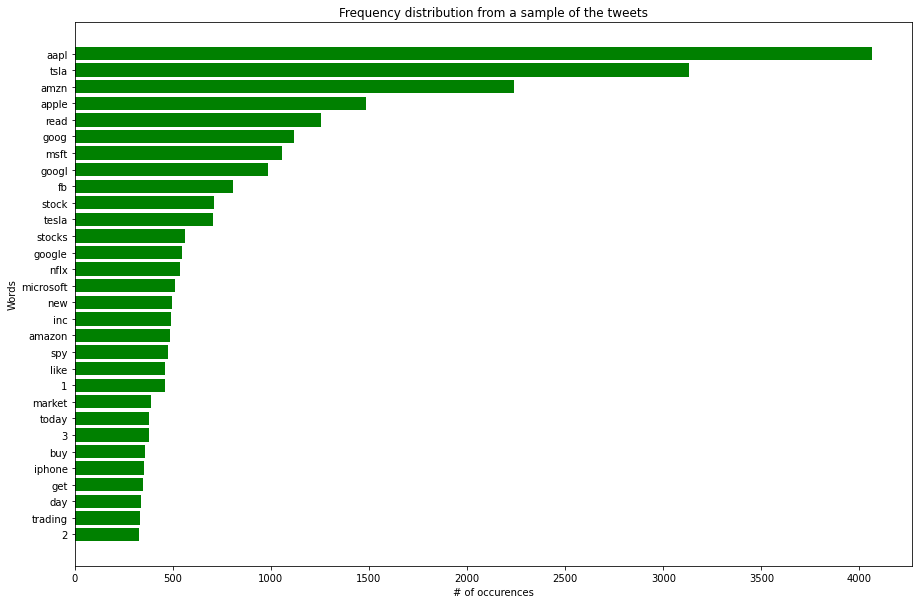

In [257]:
common_words = np.flip(common_words, axis=0)
bar_words = common_words[:, 0]
bar_occu = common_words[:, 1].astype(int)
bar_x = [i for i, _ in enumerate(bar_words)]

plt.figure(figsize=(15, 10))
plt.barh(bar_x, bar_occu, color='green')
plt.xlabel("# of occurences")
plt.ylabel("Words")
plt.title("Frequency distribution from a sample of the tweets")

plt.yticks(bar_x, bar_words)

plt.show()

The first 30 words consist mainly of companies' names and stock ticks as we can expect. But at the bottom there we can see words like \"like\" and "buy". This is very important, because they express some sort of sentiment.

### 4. Hypotheses

There are two main ways that social media could affect the market.
   1. The overall **amount of tweets** about a company raises the interest in its stocks, which results into more transactions being made (positions being closed and opened). The metric which tracks how much a stock is being traded is called **"Trading Volume"**. We can look for a correlation between the traded volume of a stock and how much people "talked" about it the previous day. 
       * The **null hypothesis** here is: There is *no correlation* between the amount of tweets about a company with the volume of its stock traded the following day.
       * And the **alternate hypothesis**: The *is a correlation* between the amount of tweets about a company with the volume of its stock traded the following day.


   2. Another important detail is what actually we're the people saying. In other words we would like to know if the general public opinion correlates in some way with the price's fluctuation. And what I mean by public opinion is whether the majority of the statements about a company made *online* are **positive or negative**. We will look at the correlation of the **average sentiment** of all tweets about a company and its **stock price** the following day.
       * **Null hypothesis**: There is *no correlation* between the ratio of positive/negative tweets about a company with the price of its stock on the same day.
       * And the **alternate hypothesis**: There *is a correlation* between the ratio of positive/negative tweets about a company with the price of its stock on the same day.

To test the our hypotheses we can use a correlation coefficient. The most common of these are the *Pearson correlation coefficient* and the *Spearman's rank correlation*. The first one is sensitive only to a linear relationship between two variables, which is not what we are looking for. The *Spearman's rank correlation coefficient* however is a lot more robust (sensitive to *non-linear relationships*) than Pearson's. That is why we will use it for this project.

### 5. Trading Volume and Amount of tweets

To look at the data for the individual stocks we first have to split the tweets dataset into different parts depending on what company they are about. We can create a function which does this for us, because will have to apply again later.

In [104]:
# Take the tickers which we have by looking at the unique values of the ticker_symbol column
tickers = tweets.ticker_symbol.unique().categories.tolist()

def split_by_ticker(df: pd.DataFrame):
    """  
    Split the dataframe into a list of dataframes based on the ticker_symbol column
    """
    return [df[df.ticker_symbol == ticker] for ticker in tickers]

tweets_by_company = split_by_ticker(tweets)

Now we want to group the tweet data based on the date of the tweet.

In [105]:
tweets_by_date = [t_by_company.groupby('date').size() for t_by_company in tweets_by_company]
tweets_by_date[0].head(5)

date
2015-01-01 00:00:57    1
2015-01-01 00:01:36    1
2015-01-01 00:10:05    3
2015-01-01 00:10:16    1
2015-01-01 00:10:17    3
dtype: int64

As we can see if we just group by the date column it also takes the time of day into account. We don't want that. To group only by the day we have to use a pandas Grouper class.

In [106]:
# The pandas Grouper class allows us to use a "freq" parameter which specifies
# the interval by which we would like to group our datetime objects
tweets_by_date = [t_by_company.groupby(pd.Grouper(key="date", freq="D")).size() for t_by_company in tweets_by_company]
tweets_by_date[0].head(5)

date
2015-01-01    280
2015-01-02    809
2015-01-03    231
2015-01-04    270
2015-01-05    891
Freq: D, dtype: int64

This gives us exactly what we want. We know which dataframe corresponds to which company by its index and the "ticks" list. Now we want to compare this data to the Volume of the given stock, again grouped by day.

Here after we split the data by ticker symbol just like we did for the tweets, we can simply remove all unnecessary columns, because the data is already given to us by date.

In [311]:
# stocks_by_company = [stocks[stocks.ticker_symbol == ticker] for ticker in tickers]
tickers

['AAPL', 'AMZN', 'TSLA', 'GOOG', 'MSFT', 'GOOGL']